In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from collections import Counter

In [2]:
np.random.seed(9439) #p1 wins in depth 4

In [3]:
import randomgames as rg

In [4]:
# these libraries are used while debugging
import importlib
import pdb
importlib.reload(rg)

<module 'randomgames' from 'C:\\Github\\RLGames\\randomgames.py'>

In [5]:
game = rg.TwoPlayerGame(minactions=2, maxactions=2, minpayoffs=2, maxpayoffs=2, maxdepth=4, ties=False)
game.solve()

In [6]:
print(game)

Action(id: 0, player: 0, selected: 1, value: (1, -1))
:-Action(id: 1, player: 1, selected: 0, value: (-1, 1))
:-:-Action(id: 17, player: 0, selected: 0, value: (-1, 1))
:-:-:-Action(id: 25, player: 1, selected: 0, value: (-1, 1))
:-:-:-:-PayOff(id: 29, value: (-1, 1))
:-:-:-:-PayOff(id: 30, value: (1, -1))
:-:-:-Action(id: 26, player: 1, selected: 1, value: (-1, 1))
:-:-:-:-PayOff(id: 27, value: (1, -1))
:-:-:-:-PayOff(id: 28, value: (-1, 1))
:-:-Action(id: 18, player: 0, selected: 0, value: (1, -1))
:-:-:-Action(id: 19, player: 1, selected: 0, value: (1, -1))
:-:-:-:-PayOff(id: 23, value: (1, -1))
:-:-:-:-PayOff(id: 24, value: (1, -1))
:-:-:-Action(id: 20, player: 1, selected: 1, value: (-1, 1))
:-:-:-:-PayOff(id: 21, value: (1, -1))
:-:-:-:-PayOff(id: 22, value: (-1, 1))
:-Action(id: 2, player: 1, selected: 0, value: (1, -1))
:-:-Action(id: 3, player: 0, selected: 1, value: (1, -1))
:-:-:-Action(id: 11, player: 1, selected: 1, value: (-1, 1))
:-:-:-:-PayOff(id: 15, value: (1, -1))
:-

In [67]:
game.print_solution_path()

Action(id: 0, player: 0, selected: 1, value: (1, -1))
:-Action(id: 2, player: 1, selected: 0, value: (1, -1))
:-:-Action(id: 3, player: 0, selected: 1, value: (1, -1))
:-:-:-Action(id: 12, player: 1, selected: 0, value: (1, -1))
:-:-:-:-PayOff(id: 13, value: (1, -1))
Player 0 wins


In [12]:
def estim_val(child, agentid, netwins, visits, pseudo=1.):
    if isinstance(child, rg.PayOffNode):
        val = child.payoff[agentid]
    else:
        idx = child.nodeid
        val = netwins[idx] / (pseudo + visits[idx]) if visits[idx] > 0 else 0.
    return val

def agent_choose(node, agentid, netwins, visits):
    assert isinstance(node, rg.ActionNode)
    values = [estim_val(x, agentid, netwins, visits) for x in node.children]
    bestvalue = np.max(values)
    choice = np.random.choice([i for i, x in enumerate(values) if x==bestvalue])
    return node.children[choice] 

def env_choose(node, valuemap, envskill):
    assert isinstance(node, rg.ActionNode)
    actions = [x.nodeid for x in node.children]
    if np.random.rand() > envskill:
        choice = np.random.choice(len(actions))
    else:    
        values = [valuemap[x] for x in actions]
        bestvalue = np.max(values)
        choice = np.random.choice([i for i, x in enumerate(values) if x==bestvalue])
    return node.children[choice] 
       
def play_one_game_against_env(game, netwins, visits, valuemap, agentid=0, envskill=.5):
    "Start at root, play one game until end, and propagate back the outcome"
    
    # Play until end of game, starting from the root
    curr_node = game.root
    while not isinstance(curr_node, rg.PayOffNode):
        if curr_node.player == agentid:
            curr_node = agent_choose(curr_node, agentid, netwins, visits)
        else:
            curr_node = env_choose(curr_node, valuemap, envskill)
            
    # Player payoff
    outcome = curr_node.payoff[agentid]
    
    # Now trace back path and add outcome to agents netwins
    while not curr_node.is_root():
        curr_node = curr_node.parent
        netwins[curr_node.nodeid] = netwins[curr_node.nodeid] + outcome
        visits[curr_node.nodeid] = visits[curr_node.nodeid] + 1
        
    return outcome

In [69]:
# build the value fun from the solved game for player 1
envid = 1
valuemap = game.valuemap(envid)


[(0, -1), (2, -1), (4, -1), (6, 1), (8, 1), (7, 1), (5, -1), (10, -1), (9, -1), (3, -1), (12, -1), (14, -1), (13, -1), (11, 1), (16, 1), (15, -1), (1, 1), (18, -1), (20, 1), (22, 1), (21, -1), (19, -1), (24, -1), (23, -1), (17, 1), (26, 1), (28, 1), (27, -1), (25, 1), (30, -1), (29, 1)]


In [70]:
# this will store number of wins and node visits for each player
netwins=Counter()
visits=Counter()

ngames = 100
results = np.zeros(ngames)
for i in range(ngames):
    results[i] = play_one_game_against_env(game, netwins, visits, valuemap, agentid=0, envskill=0.5)

In [71]:
netwins

Counter({0: 98, 2: 98, 3: 50, 4: 48, 5: 49, 6: -1, 12: 50})

In [72]:
visits

Counter({0: 100, 2: 100, 3: 50, 4: 50, 5: 49, 6: 1, 12: 50})

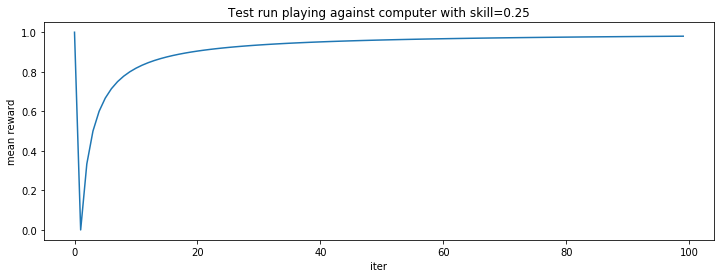

In [73]:
plt.figure(figsize=(12, 4))
cumsum_reward = np.cumsum(results)
cummean_reward = [cumsum_reward[i] / (i+1.0) for i in range(ngames)]
plt.plot(cummean_reward)
plt.title('Test run playing against computer with skill=0.5')
plt.xlabel('iter')
plt.ylabel('mean reward')
plt.show()

Now a more complicated game

In [8]:
np.random.seed(106897)

In [27]:
game2 = rg.TwoPlayerGame(minactions=2, maxactions=2, minpayoffs=2, maxpayoffs=2, maxdepth=20, ties=False)
game2

Tree with 2097151 nodes

In [28]:
game2.solve()
game2.print_solution_path()

Action(id: 0, player: 0, selected: 0, value: (-1, 1))
:-Action(id: 1, player: 1, selected: 0, value: (-1, 1))
:-:-Action(id: 1048577, player: 0, selected: 0, value: (-1, 1))
:-:-:-Action(id: 1572865, player: 1, selected: 0, value: (-1, 1))
:-:-:-:-Action(id: 1835009, player: 0, selected: 0, value: (-1, 1))
:-:-:-:-:-Action(id: 1966081, player: 1, selected: 0, value: (-1, 1))
:-:-:-:-:-:-Action(id: 2031617, player: 0, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-Action(id: 2064385, player: 1, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-:-Action(id: 2080769, player: 0, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-:-:-Action(id: 2088961, player: 1, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-:-:-:-Action(id: 2093057, player: 0, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-:-:-:-:-Action(id: 2095105, player: 1, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-:-:-:-:-:-Action(id: 2096129, player: 0, selected: 0, value: (-1, 1))
:-:-:-:-:-:-:-:-:-:-:-:-:-Action(id: 2096641, player: 1, selected: 0, value:

In [34]:
envid=0
agentid=1
valuemap2=game2.valuemap(envid)

skills = [0., 0.33, 0.66, 1.0]
ngames = 5000
results = np.zeros((ngames, len(skills)))
lam = 0.975


for k, s in enumerate(skills):
    # this will store number of wins and node visits for each player
    netwins=Counter()
    visits=Counter()
    mean_ret = 0.0
    for i in range(ngames):
        outcome = play_one_game_against_env(game2, netwins, visits, valuemap2, agentid=agentid, envskill=s)
#         mean_ret = mean_ret * lam + outcome * (1 - lam)
        mean_ret = (i * mean_ret + outcome) / (i + 1.0)
        results[i, k] = mean_ret
    print('Finished skill {}, exploring {} different states'.format(s, len(netwins.keys())))

Finished skill 0.0, exploring 4448 different states
Finished skill 0.33, exploring 5236 different states
Finished skill 0.66, exploring 5550 different states
Finished skill 1.0, exploring 5616 different states


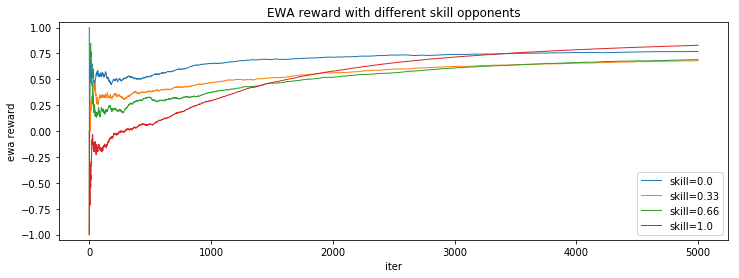

In [35]:
cols = ['skill={}'.format(s) for s in skills]
df = pd.DataFrame(results, columns=cols, index=range(ngames))
df.plot(figsize=(12, 4), linewidth=1)
plt.title('EWA reward with different skill opponents')
plt.xlabel('iter')
plt.ylabel('ewa reward')
plt.ylim(-1.05, 1.05)
plt.show()

In [36]:
netwins=Counter()
visits=Counter()
skill = .95
ngames = 10000
for i in range(ngames):
    play_one_game_against_env(game2, netwins, visits, valuemap2, agentid=agentid, envskill=skill)

In [37]:
valuetrue = game2.valuemap(agentid)
for x in sorted(visits.keys()):
    print('id: {}, true: {}, estim: {:.2f}, netwins:{}, N: {}'.format(x, valuetrue[x], netwins[x]/visits[x], netwins[x], visits[x]))

id: 0, true: 1, estim: 0.84, netwins:8440, N: 10000
id: 1, true: 1, estim: 0.90, netwins:4452, N: 4974
id: 2, true: 1, estim: 0.79, netwins:3988, N: 5026
id: 3, true: 1, estim: 0.79, netwins:3991, N: 5023
id: 4, true: 1, estim: -1.00, netwins:-3, N: 3
id: 5, true: 1, estim: -1.00, netwins:-1, N: 1
id: 6, true: 1, estim: -1.00, netwins:-2, N: 2
id: 7, true: 1, estim: -1.00, netwins:-1, N: 1
id: 8, true: 1, estim: -1.00, netwins:-1, N: 1
id: 10, true: 1, estim: -1.00, netwins:-1, N: 1
id: 12, true: 1, estim: -1.00, netwins:-1, N: 1
id: 13, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16398, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16400, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16402, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16404, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16406, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16407, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16664, true: 1, estim: -1.00, netwins:-1, N: 1
id: 16666, true: 1, estim: -1.00, netwins:-1, N: 1
id: 1666